# Chap04 배경과 사물 합성
- VOC 데이터셋으로부터 segmentation 영역을 추출하고 이를 다른 배경에 합성해봅니다

## 오늘 할 것은 사실 간단합니다
- 이러한 원본 이미지에서

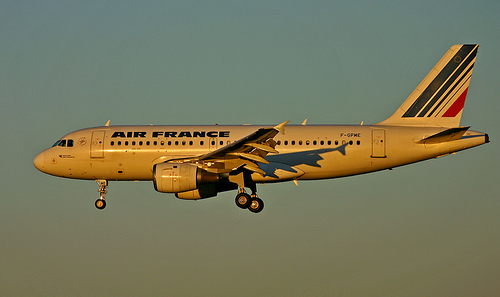

- 이만큼의 영역만 잘라내서

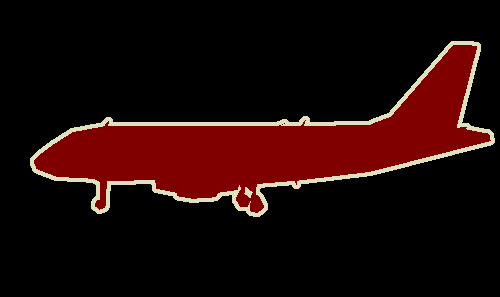

- 다른 배경에 옮겨 붙이는 것입니다
- 어떤가요? 1주차의 발합성보다는 그럴듯한가요?

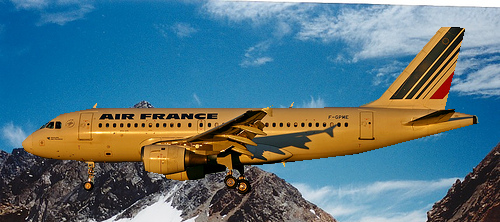

# VOC 2012 데이터셋 다운로드
- VOC 데이터셋 원본 URL에서 다운로드가 되지 않아서 아래 미러경로를 사용합니다
- YOLO 원저자의 홈페이지 입니다

In [ ]:
! wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar

In [ ]:
! tar xvf VOCtrainval_11-May-2012.tar 

# 압축을 풀고 디렉토리를 확인해봅니다
- ImageSets
  - Main 디렉토리에서 우리가 사용할 데이터세트를 확인합니다
  - train.txt 에 있는 이미지를 이용해 증강을 진행합니다
- SegmentationClass
  - 같은 클래스는 같은 색으로 마스킹되어 있습니다
  - 우리는 이 데이터세트는 사용하지 않습니다
- SegmentationObject
  - 클래스와 무관하게 오브젝트별로 각각 다른 색으로 마스킹되어 있습니다
  - 우리는 Segmentation mask로 이 데이터셋을 사용합니다
  - 이미지 내에서 오브젝트별 영역을 추출하고 이를 다른 배경위에 합성합니다 


In [ ]:
# 5,717장의 train 데이터세트를 이용해 증강을 수행해서 5,823장의 validation 데이터세트에 대한 accuracy를 올리는것이 우리의 최종 목표입니다
! cat /content/VOCdevkit/VOC2012/ImageSets/Main/train.txt  | wc -l
! cat /content/VOCdevkit/VOC2012/ImageSets/Main/val.txt  | wc -l

## 이미지 몇개를 눈으로 확인해볼까요?
- 어디서 본것같은 이미지네요?
- 1주차에서 봤던 기차 이미지 입니다
- 여기서 보이는 색깔을 잘 기억해둡시다

In [ ]:
import cv2

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False

image = cv2.imread('VOCdevkit/VOC2012/SegmentationObject/2007_000042.png')

if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('segmentation', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## 원본 이미지를 확인해볼까요?
- SegmentationObject 는 png도 되어있고, 원본 이미지는 JPEGImages 라는 디렉토리에 jpg 로 존재합니다

In [ ]:
import cv2

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


image = cv2.imread('VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg')

if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('train', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 이제 오브젝트영역만 추출해볼까요?
- VOC 2012 데이터셋 전체에 대해 돌리면 시간이 오래걸리니까 몇개만 추출해서 테스트 해봅니다

In [ ]:
import io
import os
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import traceback
import xml.etree.ElementTree as Et


# 읽을 파일이 3개 입니다.
# 원본파일, 세그멘테이션 마스크, 라벨링 파일
original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

# 추출한 이미지를 저장할 경로입니다
save_path = '/content/newImages'
os.makedirs(save_path, exist_ok=True)

print(original_image_path)
print(segmented_image_path)
print(annotation_path)

# 먼저 라벨링 파일을 읽고 오브젝트 영역을 추출합니다
xml = open(annotation_path, "r")
tree = Et.parse(xml)
root = tree.getroot()

size = root.find("size")
width = size.find("width").text
height = size.find("height").text
channels = size.find("depth").text
objects = root.findall("object")

# 원본파일과 세그멘테이션 마스크를 읽고나서 오브젝트 영역을 돌기 시작합니다
original_image = cv2.imread(original_image_path)
segmented_image = cv2.imread(segmented_image_path)

for i, obj in enumerate(objects):
    # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
    name = obj.find("name").text
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    print("[original] class : {}\nxmin : {}\nymin : {}\nxmax : {}\nymax : {}\n".format(name, xmin, ymin, xmax, ymax))    

    # 오브젝트 좌표내에서 SegmentationObject 대표색상 검출(검정색 제외)
    # 이 시점에서 sgementation 마스크 이미지가 한번 잘립니다
    # 위에서 보았던 segmentation 마스크의 2개 영역을 떠올려주세요
    segmented_cropped_image = segmented_image.copy()[ymin: ymax, xmin: xmax]

    # 차원을 축소합니다. 왜 그럴까요?
    # 가로, 세로 성분과 무관하게 픽셀단위로 대표색상을 추출하기 위함입니다
    # 이어서 사용할 np.unique 를 사용하기 위함인 것이지요
    segmented_image_arr = (np.array(segmented_cropped_image)).reshape(-1,3)

    # colors, counts 에는 어떤 값이 떨어질까요?
    # black[0 0 0] 10,563회, red [0 0 128] 46,861회, border 색깔 [192 224 244] 4,907회 등장합니다
    # blue가 segmentation 영역이겠지요

    # colors
    # [[  0   0   0]
    # [  0   0 128]
    # [192 224 224]]
    
    # counts
    # [10563 46861  4907]
    colors, counts = np.unique(segmented_image_arr, axis=0, return_counts=1)

    # black을 제거하는 과정입니다
    counts = counts.tolist()
    colors = colors.tolist()    
    black_index = colors.index([0,0,0])    

    del colors[black_index]
    del counts[black_index] 

    # 이제 이렇게 되는거죠
    # 오브젝트에 대한 border와 본체(?)의 마스크, 이렇게 2개가 남는거죠

    # colors
    # [  0   0 128]
    # [192 224 224]]
    
    # counts
    # [46861  4907]

    # border와 본체 중에 면적이 넓은게 무엇일까요? 당연히? 본체이겠지요
    # 즉, 이 구문은 본체의 마스크 색상을 잡아내는 과정이 됩니다
    max_color = colors[counts.index(max(counts))]
    # 46861이 나온 [  0   0 128] 이 되겠지요
    print('max_color', max_color)  

    # SegmentationObject 이미지내 대표색상 영역을 기준으로 원본이미지 배경 제거    
    original_image_arr = (np.array(original_image.copy())).reshape(-1,3)
    segmented_image_arr = (np.array(segmented_image.copy())).reshape(-1,3)

    # 원본 이미지에서 segmentation 마스크 영역에 해당하는 부분만 제외하고 모두 검정색으로 만듭니다
    # segmentation 마스크 이미지에서도 순수하게 오브젝트 본체 영역만 남깁니다
    for s, pixel in enumerate(segmented_image_arr):
        if not (pixel == max_color).all():
            original_image_arr[s] = [0,0,0]
            segmented_image_arr[s] = [0,0,0]


    # 저장
    # 이미지로 만들기 위해 다시 이미지였을때(?)의 원본 shape으로 바꿔줍니다
    original_image_arr = original_image_arr.reshape(original_image.shape)
    segmented_image_arr = segmented_image_arr.reshape(segmented_image.shape)

    # 파일명 중복을 방지하기 위해 i 와 클래스명을 이용합니다
    obj_original_image_filename = '{}_{}_{}'.format(str(i+1), name, os.path.basename(original_image_path))
    obj_segmented_image_filename = '{}_{}_{}'.format(str(i+1), name, os.path.basename(segmented_image_path))

    obj_original_image_path = os.path.join(save_path, obj_original_image_filename)
    obj_segmented_image_path = os.path.join(save_path, obj_segmented_image_filename)

    cv2.imwrite(obj_original_image_path, original_image_arr)
    cv2.imwrite(obj_segmented_image_path, segmented_image_arr)

# 추출한 이미지와 세그멘테이션 마스크를 확인해봅시다

In [ ]:
import cv2
colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False

# 원본 이미지에서 segmentation mask가 붉은색인 영역만 추출된 이미지
image = cv2.imread('/content/newImages/1_train_2007_000042.jpg')
if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('train', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# segmentation mask 중에서 붉은색만 추출된 이미지
image = cv2.imread('/content/newImages/1_train_2007_000042.png')

if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('train', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
import cv2
colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False

# 원본 이미지에서 segmentation mask가 초록색인 영역만 추출된 이미지
image = cv2.imread('/content/newImages/2_train_2007_000042.jpg')
if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('train', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# segmentation mask 중에서 초록색만 추출된 이미지
image = cv2.imread('/content/newImages/2_train_2007_000042.png')

if colab_env:
    cv2_imshow(image)

else:
    cv2.imshow('train', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 함수 하나 만들어둡시다
- 세그멘테이션 마스크에서 border 색상을 제거하는 함수 입니다
- 유용하게 사용할 예정입니다

In [ ]:
import io
import os
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import numpy as np
import cv2
import traceback
import xml.etree.ElementTree as Et

def remove_border(annotation_path, jpeg_image_path, segmented_image_path):
    original_image = cv2.imread(jpeg_image_path)

    xml = open(annotation_path, "r")
    tree = Et.parse(xml)
    root = tree.getroot()

    # Annotation 파싱
    size = root.find("size")
    width = size.find("width").text
    height = size.find("height").text
    channels = size.find("depth").text
    objects = root.findall("object")

    segmented_image = cv2.imread(segmented_image_path)

    segmented_image_arr = (np.array(segmented_image)).reshape(-1,3)

    colors, counts = np.unique(segmented_image_arr, axis=0, return_counts=1)

    counts = counts.tolist()
    colors = colors.tolist()    
    black_index = colors.index([0,0,0])    

    del colors[black_index]
    del counts[black_index] 
    max_color = colors[counts.index(max(counts))]

    # SegmentationObject 이미지내 대표색상 영역을 기준으로 원본이미지 배경 제거    
    original_image_arr = (np.array(original_image.copy())).reshape(-1,3)

    for s, pixel in enumerate(segmented_image_arr):
        if not (pixel == max_color).all():
            segmented_image_arr[s] = [0,0,0]

    segmented_image_arr = segmented_image_arr.reshape(segmented_image.shape)

    return segmented_image_arr

In [ ]:
# 반복적으로 if else 복사 붙여넣기 하기 번거로워서 이제는 함수로 따로 빼겠습니다
import cv2
colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False
    
def display_image(image):
    if colab_env:
        cv2_imshow(image)

    else:
        cv2.imshow('train', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# 함수가 잘 도는지 테스트 해봅시다
- 원본 이미지
- 세그멘테이션 마스크
- 세그멘테이션 마스크에서 border 제거

In [ ]:
original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_002470.jpg'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_002470.xml'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_002470.png'

display_image(cv2.imread(original_image_path))
display_image(cv2.imread(segmented_image_path))
display_image(remove_border(annotation_path, original_image_path, segmented_image_path))

# 배경 이미지를 추출해봅시다
- 아주 단순하게 생각해서 아래 중 하나만 충족하면 배경이 될 수 있겠습니다
  - 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는데 xmin 왼쪽 공간이 새로 붙일 오브젝트보다 크다면
  - 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는데 xmax 오른쪽 공간이 새로 붙일 오브젝트보다 크다면
  - 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는데 ymin 위쪽 공간이 새로 붙일 오브젝트보다 크다면
  - 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는데 ymax 아래쪽 공간이 새로 붙일 오브젝트보다 크다면
- 위에서 추출한 기차를 기준으로 배경이 될 수 있는 이미지를 추출해봅시다

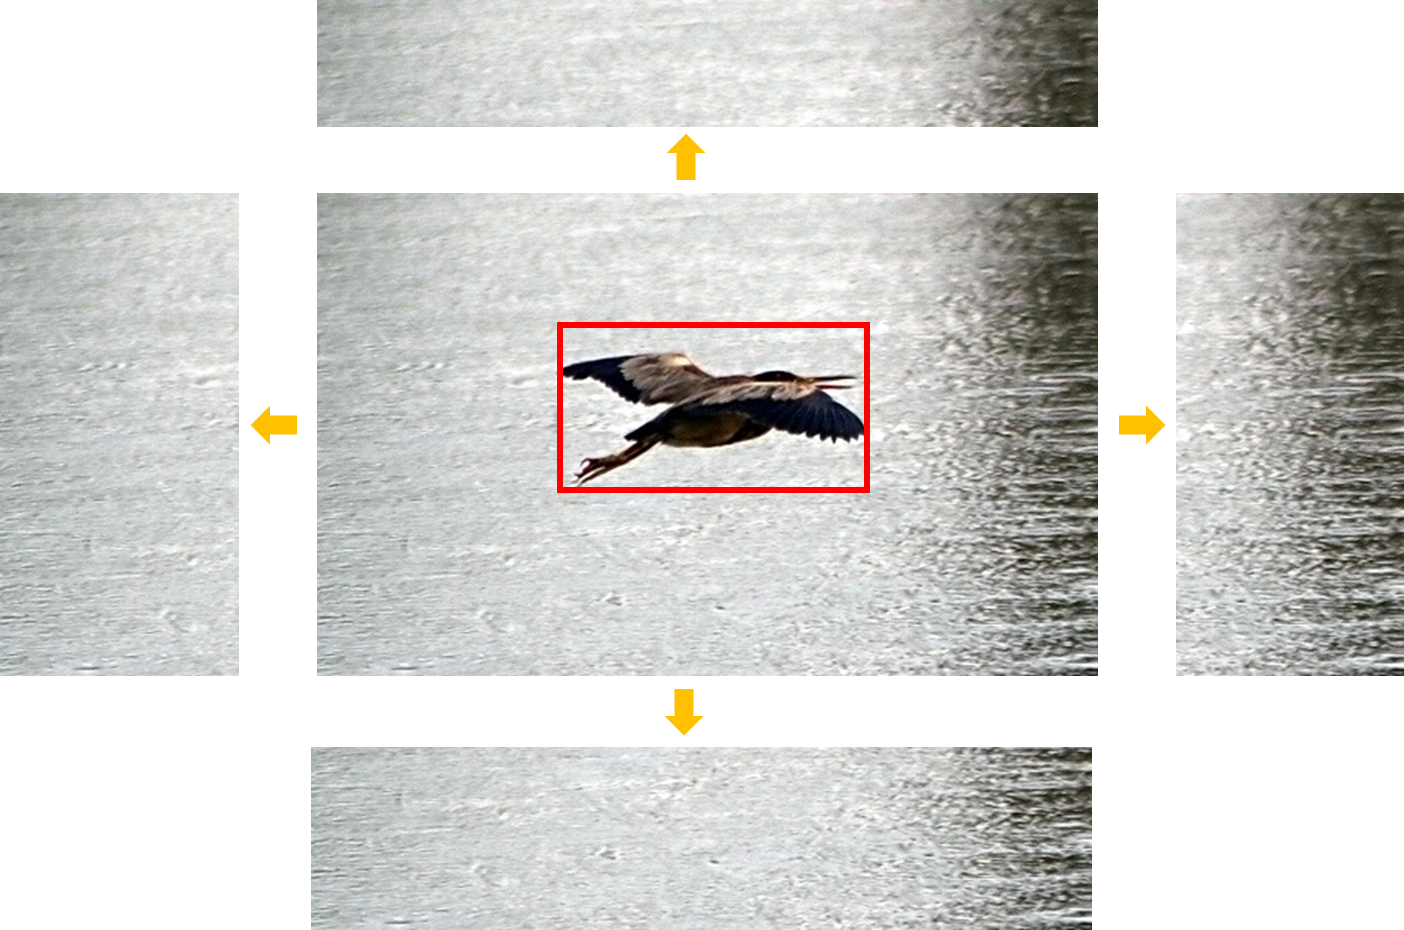

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

image = cv2.imread(original_image_path)
print('############################### 오브젝트 추출 이미지 #########################################')
display_image(image)
print('##############################################################################################')
print('\n\n')

xml = open(annotation_path, "r")
tree = Et.parse(xml)
root = tree.getroot()

objects = root.findall("object")
original_image = cv2.imread(original_image_path)
segmented_image = cv2.imread(segmented_image_path)


# VOC 2012 원본 이미지가 있는 디렉토리에서 루프를 돕니다
background_jpg_path = '/content/VOCdevkit/VOC2012/JPEGImages'
background_xml_path = '/content/VOCdevkit/VOC2012/Annotations'
files = os.listdir(background_jpg_path)

# 우리가 사용할 train 데이터세트 파일명이 들어있는 텍스트입니다. 확장자는 제외되어 있습니다.
train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'

def display_image(image):
    if colab_env:
        cv2_imshow(image)

    else:
        cv2.imshow('train', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

train_txt_file = open(train_txt, 'r')
train_files = train_txt_file.readlines()
trains = [t.strip() for t in train_files]
    
# 루프가 2개 입니다
# 첫번째 루프가 배경 대상이 되는 이미지를 찾는 루프이고
# 두번째 루프가 배경에 들어갈만한 이미지를 찾는 루프입니다
for train in trains:
    background_jpg = os.path.join(background_jpg_path, train) + '.jpg'
    background_img = cv2.imread(background_jpg)

    background_xml = open(os.path.join(background_xml_path, train) + '.xml', "r")
    background_tree = Et.parse(background_xml)
    background_root = background_tree.getroot()
    background_objects = background_root.findall("object")
    background_size = background_root.find("size")
    background_width = int(background_size.find("width").text)
    background_height = int(background_size.find("height").text)

    # 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는게 아니라면 무시
    if len(background_objects) > 1:
        continue

    # 파일 하나마다 이중루프를 돕니다. 하나의 파일 내에서 오브젝트끼리 영역이 겹치는지 비교를 할 것이기 때문입니다
    for i, background_object in enumerate(background_objects):
        background_name = background_object.find("name").text
        background_bndbox = background_object.find("bndbox")
        background_xmin = int(background_bndbox.find("xmin").text)
        background_ymin = int(background_bndbox.find("ymin").text)
        background_xmax = int(background_bndbox.find("xmax").text)
        background_ymax = int(background_bndbox.find("ymax").text)

        for obj in objects:
            # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
            name = obj.find("name").text
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            object_width = xmax - xmin
            object_height = ymax - ymin

            # 어떤 VOC2012 이미지의 xmin 왼쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_xmin > object_width and background_height > object_height:
                print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                background_img_crop = background_img[:,:background_xmin]
                display_image(background_img_crop)
                break

            # 어떤 VOC2012 이미지의 xmax 오른쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if (background_width - background_xmax) > object_width and background_height > object_height:
                print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                background_img_crop = background_img[:, background_xmax:background_width]
                display_image(background_img_crop)
                break
            
            # 어떤 VOC2012 이미지의 ymin 위쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and background_ymin > object_height:
                print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                background_img_crop = background_img[:background_ymin,:]
                display_image(background_img_crop)
                break
            
            # 어떤 VOC2012 이미지의 ymax 아래쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and (background_height - background_ymax) > object_height:
                print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                background_img_crop = background_img[background_ymax:background_height, :]
                display_image(background_img_crop)
                break

# 제대로 추출된게 맞는지 확인해봅시다
- 배경이미지로 추출된 이미지의 원본을 확인해봅시다

In [ ]:
display_image(cv2.imread('/content/VOCdevkit/VOC2012/JPEGImages/2008_000095.jpg'))
display_image(cv2.imread('/content/VOCdevkit/VOC2012/JPEGImages/2008_000148.jpg'))

## 배경이 잘 추출되었나요?
- 만약 오브젝트로 보이는 것이 존재한다면 왜그럴까요?
- 3주차에 배웠던 방법으로 라벨링 영역을 시각화 해봅시다
- 오브젝트가 존재하지만 라벨링이 되지 않은 경우 이러한 오류가 발생합니다

In [ ]:
import cv2
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False



image = cv2.imread('/content/VOCdevkit/VOC2012/JPEGImages/2008_003168.jpg')

with open ('/content/VOCdevkit/VOC2012/Annotations/2008_003168.xml', 'r', encoding='utf8') as xml:

    tree = Et.parse(xml)
    
    root = tree.getroot()

    objects = root.findall("object")
    for _object in objects:
        name = _object.find("name").text
        bndbox = _object.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0,0,256), 2)
        
        cv2.putText(image, name, (xmin, ymin), cv2.FONT_HERSHEY_PLAIN , 3, (255,0,255))

        
display_image(image)

# 이제는 분리된 이미지와 세그멘테이션 마스크를 이용해서 다른 배경에 붙여봅시다
- 일단 원본 라벨링에 오류가 없어서 배경 분리가 제대로 되었다고 보고 진행해봅시다
- 배경의 중앙에 새로운 오브젝트를 붙이는 예제입니다
- 이미지가 잘 붙었나요? 발합성인가요?

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

image = cv2.imread(original_image_path)
cv2_imshow(image)

cv2.waitKey(0)
cv2.destroyAllWindows()

xml = open(annotation_path, "r")
tree = Et.parse(xml)
root = tree.getroot()

objects = root.findall("object")
original_image = cv2.imread(original_image_path)
segmented_image = cv2.imread(segmented_image_path)


# VOC 2012 원본 이미지가 있는 디렉토리에서 루프를 돕니다
background_jpg_path = '/content/VOCdevkit/VOC2012/JPEGImages'
background_xml_path = '/content/VOCdevkit/VOC2012/Annotations'
files = os.listdir(background_jpg_path)

# 우리가 사용할 train 데이터세트 파일명이 들어있는 텍스트입니다. 확장자는 제외되어 있습니다.
train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'

train_txt_file = open(train_txt, 'r')
train_files = train_txt_file.readlines()
trains = [t.strip() for t in train_files]

    
for train in trains:
    background_jpg = os.path.join(background_jpg_path, train) + '.jpg'
    background_img = cv2.imread(background_jpg)

    background_xml = open(os.path.join(background_xml_path, train) + '.xml', "r")
    background_tree = Et.parse(background_xml)
    background_root = background_tree.getroot()
    background_objects = background_root.findall("object")
    background_size = background_root.find("size")
    background_width = int(background_size.find("width").text)
    background_height = int(background_size.find("height").text)

    # 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는게 아니라면 무시
    if len(background_objects) > 1:
        continue

    # 파일 하나마다 이중루프를 돕니다. 하나의 파일 내에서 오브젝트끼리 영역이 겹치는지 비교를 할 것이기 때문입니다
    for i, background_object in enumerate(background_objects):
        background_name = background_object.find("name").text
        background_bndbox = background_object.find("bndbox")
        background_xmin = int(background_bndbox.find("xmin").text)
        background_ymin = int(background_bndbox.find("ymin").text)
        background_xmax = int(background_bndbox.find("xmax").text)
        background_ymax = int(background_bndbox.find("ymax").text)

        for obj in objects:
            # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
            name = obj.find("name").text
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            object_width = xmax - xmin
            object_height = ymax - ymin

            # 어떤 VOC2012 이미지의 xmin 왼쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_xmin > object_width and background_height > object_height:
                print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                background_img_crop = background_img[:,:background_xmin]
                
                x_start = int((background_xmin - (xmax-xmin))/2)
                y_start = int((background_height - (ymax-ymin))/2)  
                
                background_img_crop[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]
                display_image(background_img_crop)
                break

            # 어떤 VOC2012 이미지의 xmax 오른쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if (background_width - background_xmax) > object_width and background_height > object_height:
                print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                background_img_crop = background_img[:, background_xmax:background_width]
                
                x_start = int(((background_width - background_xmax) - (xmax-xmin))/2)                    
                y_start = int((background_height - (ymax-ymin))/2)
                
                background_img_crop[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]
                display_image(background_img_crop)
                break
            
            # 어떤 VOC2012 이미지의 ymin 위쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and background_ymin > object_height:
                print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                background_img_crop = background_img[:background_ymin,:]
                
                x_start = int((background_width - (xmax-xmin))/2)
                y_start = int((background_ymin - (ymax-ymin))/2)
                
                background_img_crop[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]
                display_image(background_img_crop)
                break
            
            # 어떤 VOC2012 이미지의 ymax 아래쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and (background_height - background_ymax) > object_height:
                print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                background_img_crop = background_img[background_ymax:background_height, :]
                
                x_start = int((background_width - (xmax-xmin))/2)
                y_start = int(((background_height - background_ymax) - (ymax-ymin))/2)
                
                background_img_crop[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]

                display_image(background_img_crop)
                break

## 이번에는 새로운 오브젝트의 segmentationobject 마스크를 이용해서 붙여넣습니다

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

image = cv2.imread(original_image_path)
cv2_imshow(image)

cv2.waitKey(0)
cv2.destroyAllWindows()

xml = open(annotation_path, "r")
tree = Et.parse(xml)
root = tree.getroot()

objects = root.findall("object")
original_image = cv2.imread(original_image_path)
segmented_image = cv2.imread(segmented_image_path)


# VOC 2012 원본 이미지가 있는 디렉토리에서 루프를 돕니다
background_jpg_path = '/content/VOCdevkit/VOC2012/JPEGImages'
background_xml_path = '/content/VOCdevkit/VOC2012/Annotations'
files = os.listdir(background_jpg_path)

# 우리가 사용할 train 데이터세트 파일명이 들어있는 텍스트입니다. 확장자는 제외되어 있습니다.
train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'


with open(train_txt, 'r') as train_f:
    trains = train_f.readlines()
    trains = [t.strip() for t in trains]
    
    for train in trains:
        background_jpg = os.path.join(background_jpg_path, train) + '.jpg'
        background_img = cv2.imread(background_jpg)

        background_xml = open(os.path.join(background_xml_path, train) + '.xml', "r")
        background_tree = Et.parse(background_xml)
        background_root = background_tree.getroot()
        background_objects = background_root.findall("object")
        background_size = background_root.find("size")
        background_width = int(background_size.find("width").text)
        background_height = int(background_size.find("height").text)

        # 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는게 아니라면 무시
        if len(background_objects) > 1:
            continue

        # 파일 하나마다 이중루프를 돕니다. 하나의 파일 내에서 오브젝트끼리 영역이 겹치는지 비교를 할 것이기 때문입니다
        for i, background_object in enumerate(background_objects):
            background_name = background_object.find("name").text
            background_bndbox = background_object.find("bndbox")
            background_xmin = int(background_bndbox.find("xmin").text)
            background_ymin = int(background_bndbox.find("ymin").text)
            background_xmax = int(background_bndbox.find("xmax").text)
            background_ymax = int(background_bndbox.find("ymax").text)

            for obj in objects:
                # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
                name = obj.find("name").text
                bndbox = obj.find("bndbox")
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)

                object_width = xmax - xmin
                object_height = ymax - ymin

                # 어떤 VOC2012 이미지의 xmin 왼쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                if background_xmin > object_width and background_height > object_height:
                    print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                    background_img_crop = background_img[:,:background_xmin]
                    
                    x_start = int((background_xmin - (xmax-xmin))/2)
                    y_start = int((background_height - (ymax-ymin))/2)

                    # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                    # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                    new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                    new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                    new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                    new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                    # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                    new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                    final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)
  
                    display_image(final_image)
                    break

                # 어떤 VOC2012 이미지의 xmax 오른쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                if (background_width - background_xmax) > object_width and background_height > object_height:
                    print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                    background_img_crop = background_img[:, background_xmax:background_width]
                    
                    x_start = int(((background_width - background_xmax) - (xmax-xmin))/2)                    
                    y_start = int((background_height - (ymax-ymin))/2)

                    # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                    # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                    new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                    new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                    new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                    new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                    # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                    new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                    final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                    display_image(final_image)
                    break
                
                # 어떤 VOC2012 이미지의 ymin 위쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                if background_width > object_width and background_ymin > object_height:
                    print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                    background_img_crop = background_img[:background_ymin,:]
                    
                    x_start = int((background_width - (xmax-xmin))/2)
                    y_start = int((background_ymin - (ymax-ymin))/2)
                    
                    # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                    # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                    new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                    new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                    new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                    new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                    # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                    new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                    final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                    display_image(final_image)
                    break
                
                # 어떤 VOC2012 이미지의 ymax 아래쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                if background_width > object_width and (background_height - background_ymax) > object_height:
                    print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                    background_img_crop = background_img[background_ymax:background_height, :]
                    
                    x_start = int((background_width - (xmax-xmin))/2)
                    y_start = int(((background_height - background_ymax) - (ymax-ymin))/2)
                    
                    # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                    # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                    new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                    new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                    new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                    new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                    # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                    new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                    final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)


                    display_image(background_img_crop)
                    break

# border가 불편합니다
- 이제 기존에 만들어둔 그 함수를 유용하게 써봅시다

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

image = cv2.imread(original_image_path)
cv2_imshow(image)

cv2.waitKey(0)
cv2.destroyAllWindows()

xml = open(annotation_path, "r")
tree = Et.parse(xml)
root = tree.getroot()

objects = root.findall("object")
original_image = cv2.imread(original_image_path)


# 세그멘테이션 마스크를 그대로 읽는 대신
# segmented_image = cv2.imread(segmented_image_path)

# 이 함수를 이용해서 border를 제거한 세그멘테이션 마스크를 얻어옵니다
segmented_image = remove_border(annotation_path = annotation_path, jpeg_image_path=original_image_path, segmented_image_path=segmented_image_path)


# VOC 2012 원본 이미지가 있는 디렉토리에서 루프를 돕니다
background_jpg_path = '/content/VOCdevkit/VOC2012/JPEGImages'
background_xml_path = '/content/VOCdevkit/VOC2012/Annotations'
files = os.listdir(background_jpg_path)

# 우리가 사용할 train 데이터세트 파일명이 들어있는 텍스트입니다. 확장자는 제외되어 있습니다.
train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'

train_txt_file = open(train_txt, 'r')
train_files = train_txt_file.readlines()
trains = [t.strip() for t in train_files]
   
for train in trains:
    background_jpg = os.path.join(background_jpg_path, train) + '.jpg'
    background_img = cv2.imread(background_jpg)

    background_xml = open(os.path.join(background_xml_path, train) + '.xml', "r")
    background_tree = Et.parse(background_xml)
    background_root = background_tree.getroot()
    background_objects = background_root.findall("object")
    background_size = background_root.find("size")
    background_width = int(background_size.find("width").text)
    background_height = int(background_size.find("height").text)

    # 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는게 아니라면 무시
    if len(background_objects) > 1:
        continue

    # 파일 하나마다 이중루프를 돕니다. 하나의 파일 내에서 오브젝트끼리 영역이 겹치는지 비교를 할 것이기 때문입니다
    for i, background_object in enumerate(background_objects):
        background_name = background_object.find("name").text
        background_bndbox = background_object.find("bndbox")
        background_xmin = int(background_bndbox.find("xmin").text)
        background_ymin = int(background_bndbox.find("ymin").text)
        background_xmax = int(background_bndbox.find("xmax").text)
        background_ymax = int(background_bndbox.find("ymax").text)

        for obj in objects:
            # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
            name = obj.find("name").text
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            object_width = xmax - xmin
            object_height = ymax - ymin

            # 어떤 VOC2012 이미지의 xmin 왼쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_xmin > object_width and background_height > object_height:
                print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                background_img_crop = background_img[:,:background_xmin]
                
                x_start = int((background_xmin - (xmax-xmin))/2)
                y_start = int((background_height - (ymax-ymin))/2)

                # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                display_image(final_image)
                break

            # 어떤 VOC2012 이미지의 xmax 오른쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if (background_width - background_xmax) > object_width and background_height > object_height:
                print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                background_img_crop = background_img[:, background_xmax:background_width]
                
                x_start = int(((background_width - background_xmax) - (xmax-xmin))/2)                    
                y_start = int((background_height - (ymax-ymin))/2)

                # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                display_image(final_image)
                break
            
            # 어떤 VOC2012 이미지의 ymin 위쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and background_ymin > object_height:
                print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                background_img_crop = background_img[:background_ymin,:]
                
                x_start = int((background_width - (xmax-xmin))/2)
                y_start = int((background_ymin - (ymax-ymin))/2)
                
                # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                display_image(final_image)
                break
            
            # 어떤 VOC2012 이미지의 ymax 아래쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
            if background_width > object_width and (background_height - background_ymax) > object_height:
                print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                background_img_crop = background_img[background_ymax:background_height, :]
                
                x_start = int((background_width - (xmax-xmin))/2)
                y_start = int(((background_height - background_ymax) - (ymax-ymin))/2)
                
                # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)


                display_image(background_img_crop)
                break

# 잘린 이미지, 가려진 이미지 불편합니다
- 이제 이런 이미지들을 제외하고 진행해봅시다

In [ ]:
# 가려지지 않은 오브젝트가 총 9,626 개, 잘리지 않은 오브젝트가 7,622 개 있습니다
! cat /content/VOCdevkit/VOC2012/ImageSets/Main/train.txt | awk '{printf "/content/VOCdevkit/VOC2012/Annotations/%s.xml\n",$1}' | xargs grep   "<occluded>0"  | wc -l
! cat /content/VOCdevkit/VOC2012/ImageSets/Main/train.txt | awk '{printf "/content/VOCdevkit/VOC2012/Annotations/%s.xml\n",$1}' | xargs grep   "<truncated>0"  | wc -l

# 유용한 함수 하나 더 만들어둡시다
- 아래 3개를 파라미터로 받습니다
    - JPEGImages 디렉토리에 있는 원본 이미지
    - SegmentationObject 디렉토리에 있는 원본 이미지
    - Annotations 디렉토리에 있는 라벨링 파일
- 이미지 내에 있는 모든 라벨링된 오브젝트가 truncated 또는 occluded 이면 증강을 수행하지 않고 종료합니다

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


def create_augmented_image(original_image_path, segmented_image_path, annotation_path):

    # 이미지 내에 있는 모든 라벨링된 오브젝트가 truncated 또는 occluded 인지 판단할 변수입니다
    truncated_or_occluded_count = 0

    image = cv2.imread(original_image_path)
    cv2_imshow(image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    xml = open(annotation_path, "r")
    tree = Et.parse(xml)
    root = tree.getroot()

    objects = root.findall("object")
    original_image = cv2.imread(original_image_path)


    # 세그멘테이션 마스크를 그대로 읽는 대신
    # segmented_image = cv2.imread(segmented_image_path)

    # 이 함수를 이용해서 border를 제거한 세그멘테이션 마스크를 얻어옵니다
    segmented_image = remove_border(annotation_path = annotation_path, jpeg_image_path=original_image_path, segmented_image_path=segmented_image_path)



    # VOC 2012 원본 이미지가 있는 디렉토리에서 루프를 돕니다
    background_jpg_path = '/content/VOCdevkit/VOC2012/JPEGImages'
    background_xml_path = '/content/VOCdevkit/VOC2012/Annotations'
    files = os.listdir(background_jpg_path)

    # 우리가 사용할 train 데이터세트 파일명이 들어있는 텍스트입니다. 확장자는 제외되어 있습니다.
    train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'

    with open(train_txt, 'r') as train_f:
        trains = train_f.readlines()
        trains = [t.strip() for t in trains]
        
        for train in trains:
            background_jpg = os.path.join(background_jpg_path, train) + '.jpg'
            background_img = cv2.imread(background_jpg)

            background_xml = open(os.path.join(background_xml_path, train) + '.xml', "r")
            background_tree = Et.parse(background_xml)
            background_root = background_tree.getroot()
            background_objects = background_root.findall("object")
            background_size = background_root.find("size")
            background_width = int(background_size.find("width").text)
            background_height = int(background_size.find("height").text)

            # 어떤 VOC2012 이미지에서 오브젝트가 하나밖에 없는게 아니라면 무시
            if len(background_objects) > 1:
                continue

            # 파일 하나마다 이중루프를 돕니다. 하나의 파일 내에서 오브젝트끼리 영역이 겹치는지 비교를 할 것이기 때문입니다
            for i, background_object in enumerate(background_objects):
                background_name = background_object.find("name").text
                background_bndbox = background_object.find("bndbox")
                background_xmin = int(background_bndbox.find("xmin").text)
                background_ymin = int(background_bndbox.find("ymin").text)
                background_xmax = int(background_bndbox.find("xmax").text)
                background_ymax = int(background_bndbox.find("ymax").text)
                
                for obj in objects:

                    truncated = '0' if obj.find("truncated") == None else obj.find("truncated").text
                    occluded = '0' if obj.find("occluded") == None else obj.find("occluded").text
                    if truncated != '0':
                        print('"truncated" is {} , skip'.format(truncated))
                        truncated_or_occluded_count = truncated_or_occluded_count + 1 
                        if truncated_or_occluded_count >= len(objects):
                            print('nothing to create')
                            return
                        continue
                    elif occluded != '0':
                        print('"occluded" is {}, skip'.format(occluded))
                        truncated_or_occluded_count = truncated_or_occluded_count + 1 
                        if truncated_or_occluded_count >= len(objects):
                            print('nothing to create')
                            return
                        continue                    


                    # Annotation 내 오브젝트 기준으로 SegmentationObject 이미지를 탐색
                    name = obj.find("name").text
                    bndbox = obj.find("bndbox")
                    xmin = int(bndbox.find("xmin").text)
                    ymin = int(bndbox.find("ymin").text)
                    xmax = int(bndbox.find("xmax").text)
                    ymax = int(bndbox.find("ymax").text)

                    object_width = xmax - xmin
                    object_height = ymax - ymin

                    # 어떤 VOC2012 이미지의 xmin 왼쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                    if background_xmin > object_width and background_height > object_height:
                        print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                        background_img_crop = background_img[:,:background_xmin]
                        
                        x_start = int((background_xmin - (xmax-xmin))/2)
                        y_start = int((background_height - (ymax-ymin))/2)

                        # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                        # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                        new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                        new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                        new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                        new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                        # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                        new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                        final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)
    
                        display_image(final_image)
                        break

                    # 어떤 VOC2012 이미지의 xmax 오른쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                    if (background_width - background_xmax) > object_width and background_height > object_height:
                        print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                        background_img_crop = background_img[:, background_xmax:background_width]
                        
                        x_start = int(((background_width - background_xmax) - (xmax-xmin))/2)                    
                        y_start = int((background_height - (ymax-ymin))/2)

                        # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                        # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                        new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                        new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                        new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                        new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                        # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                        new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                        final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                        display_image(final_image)
                        break
                    
                    # 어떤 VOC2012 이미지의 ymin 위쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                    if background_width > object_width and background_ymin > object_height:
                        print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                        background_img_crop = background_img[:background_ymin,:]
                        
                        x_start = int((background_width - (xmax-xmin))/2)
                        y_start = int((background_ymin - (ymax-ymin))/2)
                        
                        # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                        # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                        new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                        new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                        new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                        new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                        # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                        new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                        final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)

                        display_image(final_image)
                        break
                    
                    # 어떤 VOC2012 이미지의 ymax 아래쪽 공간이 새로 붙일 오브젝트를 붙이기에 충분한지 확인
                    if background_width > object_width and (background_height - background_ymax) > object_height:
                        print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                        background_img_crop = background_img[background_ymax:background_height, :]
                        
                        x_start = int((background_width - (xmax-xmin))/2)
                        y_start = int(((background_height - background_ymax) - (ymax-ymin))/2)
                        
                        # 원본 이미지와 mask 이미지를 배경 이미지의 크기만큼 확장합니다
                        # 이 때 resize를 사용하지 않고 배경 이미지와 동일한 크기의 blank 이미지 중앙에 원본 이미지와 mask 이미지를 위치시킵니다 
                        new_original_image = np.zeros(background_img_crop.shape, dtype=np.uint8)
                        new_segmented_image = np.zeros(background_img_crop.shape, dtype=np.uint8)                        
                        new_original_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = original_image[ymin:ymax, xmin:xmax]            
                        new_segmented_image[y_start:y_start+ymax-ymin,x_start:x_start+xmax-xmin] = segmented_image[ymin:ymax, xmin:xmax]

                        # opencv의 copyTo 메소드를 사용하기 위해 mask 이미지는 grayscale로 바꿉니다
                        new_segmented_image = cv2.cvtColor(new_segmented_image, cv2.COLOR_BGR2GRAY)

                        final_image = cv2.copyTo(new_original_image, new_segmented_image, background_img_crop)


                        display_image(background_img_crop)
                        break

# 모든 오브젝트가 truncated 또는 occluded 인 이미지로 테스트 해봅시다

In [ ]:
original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2007_000042.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2007_000042.xml'

create_augmented_image(original_image_path, segmented_image_path, annotation_path)

# truncated, occluded 가 아닌 오브젝트가 있는 이미지로 다시 테스트 해봅시다

In [ ]:
original_image_path = 'VOCdevkit/VOC2012/JPEGImages/2008_001546.jpg'
segmented_image_path = 'VOCdevkit/VOC2012/SegmentationObject/2008_001546.png'
annotation_path = 'VOCdevkit/VOC2012/Annotations/2008_001546.xml'

create_augmented_image(original_image_path, segmented_image_path, annotation_path)

# 모든 동작을 연결해봅시다
- 1주차
  - 이미지를 불러옵니다
- 2주차
  - 트랜스폼 행렬을 정의합니다
  - 세그멘테이션 마스크를 트랜스폼 합니다
  - 같은 행렬로 원본 이미지도 트랜스폼 합니다
- 3주차
  - 트랜스폼된 영역으로 라벨링 파일을 만듭니다
- 4주차
  - 배경 이미지를 불러옵니다
  - 트랜스폼된 세그멘테이션 마스크를 이용해 이미지를 새로운 배경에 붙입니다
- 그리고 가장 중요한 5번째
  - 여러분의 장인정신

In [ ]:
jpeg_image_base = '/content/VOCdevkit/VOC2012/JPEGImages'
annotation_base = '/content/VOCdevkit/VOC2012/Annotations'
segmentation_mask_base = '/content/VOCdevkit/VOC2012/SegmentationObject'

jpeg_image_suffix = '.jpg'
segmentation_mask_suffix = '.png'
annotation_suffix = '.xml'

In [ ]:
import cv2
import os

def load_image(image_name):
    image_path = os.path.join(jpeg_image_base, image_name) + jpeg_image_suffix
    image = cv2.imread(image_path)

    return image

In [ ]:
import cv2
import os

def transform_image(image_name, matrix, size):
    annotation_path = os.path.join(annotation_base, image_name) + annotation_suffix
    image_path = os.path.join(jpeg_image_base, image_name) + jpeg_image_suffix
    segmentation_mask_path = os.path.join(segmentation_mask_base, image_name) + segmentation_mask_suffix

    jpeg_image = cv2.imread(image_path)
    segmentation_mask = remove_border(annotation_path, image_path, segmentation_mask_path)

    object_coordinate = get_object_coordinate(annotation_path)

    if object_coordinate is not None:
        transformed_jpeg_image = cv2.warpPerspective(jpeg_image, matrix, size)    
        transformed_segmentation_mask = cv2.warpPerspective(segmentation_mask, matrix, size)
        new_coordinates = cv2.perspectiveTransform(object_coordinate.reshape(-1,1,2), matrix).reshape(object_coordinate.shape)

        xmin = int(new_coordinates[3][0])
        ymin = int(new_coordinates[3][1])
        xmax = int(new_coordinates[1][0])
        ymax = int(new_coordinates[1][1])

        xmin = int(new_coordinates[0][0]) if new_coordinates[0][0] < new_coordinates[3][0] else int(new_coordinates[3][0]) 
        ymin = int(new_coordinates[0][1]) if new_coordinates[0][1] < new_coordinates[1][1] else int(new_coordinates[1][1]) 
        xmax = int(new_coordinates[1][0]) if new_coordinates[1][0] > new_coordinates[2][0] else int(new_coordinates[2][0]) 
        ymax = int(new_coordinates[2][1]) if new_coordinates[2][1] > new_coordinates[3][1] else int(new_coordinates[3][1])         
        
        xmin = 0 if xmin < 0 else xmin
        ymin = 0 if ymin < 0 else ymin
        xmax = width if xmax > width else xmax
        ymax = height if ymax > height else ymax

        transformed_annotation = [[xmin, ymin], [xmax, ymax]]

        return transformed_jpeg_image, transformed_segmentation_mask, transformed_annotation

    else:
        return None, None, None

In [ ]:
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree


def get_object_coordinate(annotation_path):
    # 원본 이미지에 원본 라벨링 영역을 그립니다
    with open (annotation_path, 'r', encoding='utf8') as xml:
        tree = Et.parse(xml)    
        root = tree.getroot()

        objects = root.findall("object")
        if len(objects) > 1:
            return None
        else:
            name = objects[0].find("name").text
            bndbox = objects[0].find("bndbox") 
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            p0 = [xmin, ymin]
            p1 = [xmax, ymin]
            p2 = [xmax, ymax]
            p3 = [xmin, ymax]
            
            org_coordinates = np.float32([p0, p1, p2, p3])

            
            return org_coordinates
        

In [ ]:
import cv2
import sys
import os
import numpy as np
import xml.etree.ElementTree as Et

colab_env = True

try:
    from google.colab.patches import cv2_imshow
except:
    colab_env = False


def get_one_background(transformed_annotation):

    xmin, ymin = transformed_annotation[0]
    xmax, ymax = transformed_annotation[1]

    train_txt = '/content/VOCdevkit/VOC2012/ImageSets/Main/train.txt'


    train_txt_file = open(train_txt, 'r')
    train_files = train_txt_file.readlines()
    trains = [t.strip() for t in train_files]

    for train in trains:
        background_jpg = os.path.join(jpeg_image_base, train) + '.jpg'
        background_img = cv2.imread(background_jpg)

        background_xml = open(os.path.join(annotation_base, train) + '.xml', "r")
        background_tree = Et.parse(background_xml)
        background_root = background_tree.getroot()
        background_objects = background_root.findall("object")
        background_size = background_root.find("size")
        background_width = int(background_size.find("width").text)
        background_height = int(background_size.find("height").text)

        if len(background_objects) > 1:
            continue

        for i, background_object in enumerate(background_objects):
            background_name = background_object.find("name").text
            background_bndbox = background_object.find("bndbox")
            background_xmin = int(background_bndbox.find("xmin").text)
            background_ymin = int(background_bndbox.find("ymin").text)
            background_xmax = int(background_bndbox.find("xmax").text)
            background_ymax = int(background_bndbox.find("ymax").text)

            object_width = xmax - xmin
            object_height = ymax - ymin

            if background_xmin > object_width and background_height > object_height:
                print(background_jpg, 'left', object_width, object_height, background_xmin, background_height)
                background_img_crop = background_img[:,:background_xmin]
                return background_img_crop

            if (background_width - background_xmax) > object_width and background_height > object_height:
                print(background_jpg, 'right', object_width, object_height, background_width - background_xmax, background_height)
                background_img_crop = background_img[:, background_xmax:background_width]
                return background_img_crop
            
            if background_width > object_width and background_ymin > object_height:
                print(background_jpg, 'top', object_width, object_height, background_width, background_ymin)
                background_img_crop = background_img[:background_ymin,:]
                return background_img_crop
            
            if background_width > object_width and (background_height - background_ymax) > object_height:
                print(background_jpg, 'bottom', object_width, object_height, background_width, background_height - background_ymax)
                background_img_crop = background_img[background_ymax:background_height, :]
                return background_img_crop

In [ ]:
display_image(load_image('2007_000027'))

In [ ]:
! cat /content/VOCdevkit/VOC2012/ImageSets/Main/aeroplane_train.txt  | grep -v '\-1' | awk '{printf "cat /content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt | grep %s\n", $1}' | bash

In [ ]:
import math

image_name = '2008_002221'

del final_image

image = load_image(image_name)
height, width, channels = image.shape
image_size = (width, height)

theta = math.radians(20)
b1, b2 = 0, 0
matrix = np.float64([[np.cos(theta), -np.sin(theta), b1],[np.sin(theta), np.cos(theta), b2], [0,0,1]])

# 원본 이미지, 원본 세그멘테이션 마스크, 원본 라벨링영역을 동일한 행렬로 트랜스폼 합니다
transformed_jpeg_image, transformed_segmentation_mask, transformed_annotation = transform_image(image_name, matrix, image_size)
print('트랜스폼된 오브젝트')
display_image(transformed_jpeg_image)
print()
print('트랜스폼된 세그멘테이션 마스크')
display_image(transformed_segmentation_mask)
print()

# 트랜스폼된 annotation 정보를 넘겨서 해당 오브젝트를 수용할 수 있는 백그라운드 이미지 한장을 얻어옵니다
background_image = get_one_background(transformed_annotation)
print('새로운 백그라운드 이미지')
display_image(background_image)
print()

# 백그라운드 이미지를 오브젝트가 속해있던 원본 이미지 사이즈로 늘립니다
background_image = cv2.resize(background_image, (width, height))

# 트랜스폼된 오브젝트, 트랜스폼된 세그멘테이션 마스크, 백그라운드 이미지를 이용해 합성을 진행합니다
final_image = cv2.copyTo(transformed_jpeg_image, cv2.cvtColor(transformed_segmentation_mask, cv2.COLOR_BGR2GRAY), background_image)
print('합성된 최종 이미지')
display_image(final_image)
print()

# 합성된 이미지 위에 트랜스폼된 라벨링 영역을 표시합니다
transformed_jpeg_image_with_label = cv2.rectangle(final_image, transformed_annotation[0], transformed_annotation[1], (0,0,255), 2)
print('합성된 최종 이미지 위에 트랜스폼된 annotation 영역')
display_image(transformed_jpeg_image_with_label)